# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr

In [4]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq
import pyarrow

## SCIP computed features

In [5]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

In [85]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202207011040_debug/").glob("*.parquet")
], axis=0)

In [8]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem[:-8])

In [87]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202207011040/features.parquet").to_pandas()

In [40]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [41]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

In [42]:
df["meta_label"] = "unknown"
chunk_size = len(df)//10 + 1
for i in range(0, 10):
    df.iloc[i*chunk_size:(i+1)*chunk_size, df.columns.get_loc("meta_label")] = df.iloc[i*chunk_size:(i+1)*chunk_size].apply(map_to_class, axis=1)

<AxesSubplot:xlabel='count', ylabel='meta_group'>

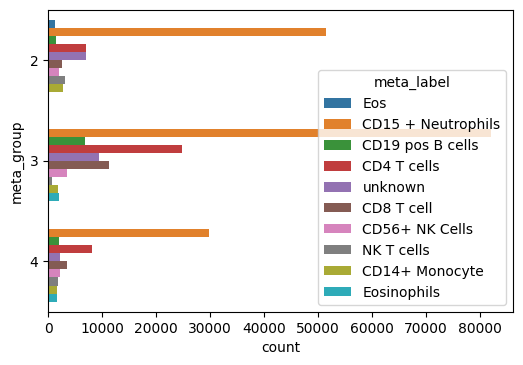

In [7]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [88]:
df["meta_label"].value_counts()

CD15 + Neutrophils    163421
CD4 T cells            39840
unknown                18560
CD8 T cell             17282
CD19 pos B cells       10438
CD56+ NK Cells          7744
CD14+ Monocyte          6207
NK T cells              5775
Eosinophils             3572
Eos                     1211
Name: meta_label, dtype: int64

In [89]:
df.shape

(274050, 2519)

In [52]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202207011040/features.parquet")

## NaN filter

In [90]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(257622, 2519)

In [91]:
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

In [92]:
df = df.drop(columns=df.columns[df.isna().all(axis=0)])
df.shape

(257622, 2519)

In [93]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]

In [94]:
glcms = pandas.DataFrame(list(map(lambda a: re.match(r"feat_?(?P<comb>combined)?_glcm_(?P<type>[^_]+)_(?P<name>[^_]+)_(?P<dist>[0-9])_(?P<channel>.+)$", a).groupdict(), cols)))

In [95]:
glcms["dist"].value_counts()

5    216
3    144
Name: dist, dtype: int64

In [96]:
glcms.groupby("dist")["type"].value_counts()

dist  type
3     std     144
5     std     144
      mean     72
Name: type, dtype: int64

In [97]:
glcms.groupby("dist")["name"].value_counts()

dist  name         
3     ASM              24
      contrast         24
      correlation      24
      dissimilarity    24
      energy           24
      homogeneity      24
5     ASM              48
      correlation      48
      energy           48
      contrast         24
      dissimilarity    24
      homogeneity      24
Name: name, dtype: int64

In [98]:
df[df[cols].isna().any(axis=1)]["meta_label"].value_counts() / df["meta_label"].value_counts()

CD14+ Monocyte        0.066702
CD15 + Neutrophils    0.046368
CD19 pos B cells      0.050971
CD4 T cells           0.047326
CD56+ NK Cells        0.046470
CD8 T cell            0.045847
Eos                   0.042781
Eosinophils           0.050305
NK T cells            0.042947
unknown               0.052176
Name: meta_label, dtype: float64

In [99]:
df = df[~df[cols].isna().any(axis=1)]

In [100]:
df.filter(regex="feat").isna().any(axis=1).sum()

69

In [101]:
df[df.filter(regex="feat").isna().any(axis=1)]["meta_label"].value_counts()

CD4 T cells           25
CD15 + Neutrophils    16
CD19 pos B cells      16
unknown                7
CD8 T cell             3
CD14+ Monocyte         1
CD56+ NK Cells         1
Name: meta_label, dtype: int64

In [102]:
df = df[~df.filter(regex="feat").isna().any(axis=1)]
df.shape

(245328, 2519)

In [103]:
df["meta_label"].value_counts()

CD15 + Neutrophils    147116
CD4 T cells            35565
unknown                16215
CD8 T cell             15481
CD19 pos B cells        9368
CD56+ NK Cells          6955
CD14+ Monocyte          5274
NK T cells              5014
Eosinophils             3266
Eos                     1074
Name: meta_label, dtype: int64

# Number of identified regions per channel 

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


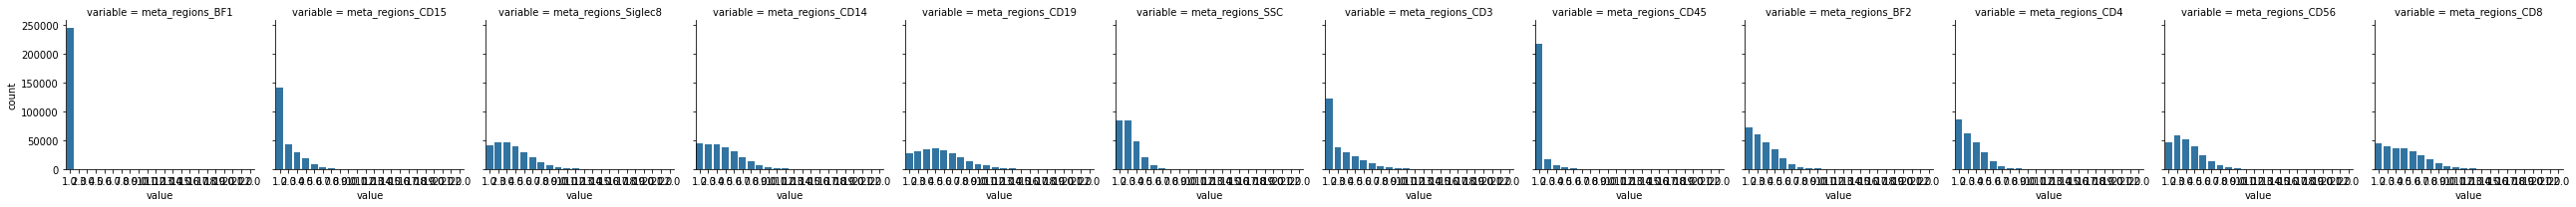

In [104]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_BF1', ylabel='feat_minor_axis_length_BF1'>

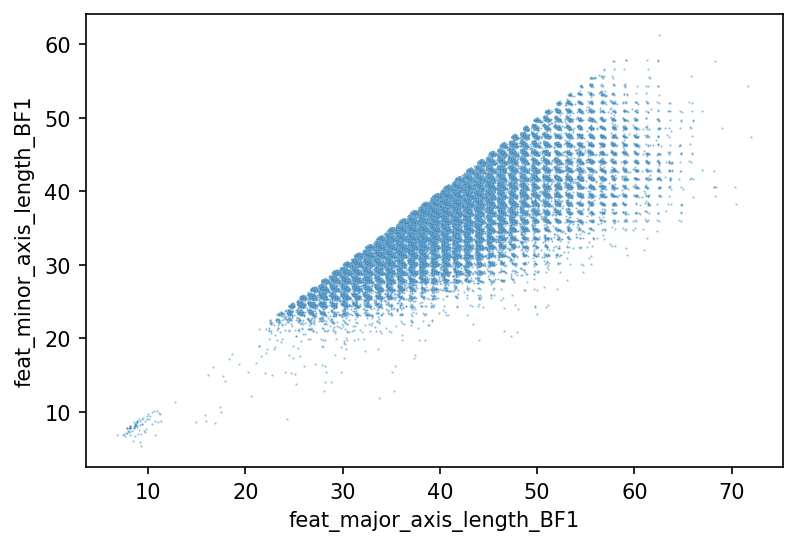

In [68]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5)

ValueError: Could not interpret value `feat_major_axis_length_DAPI` for parameter `x`

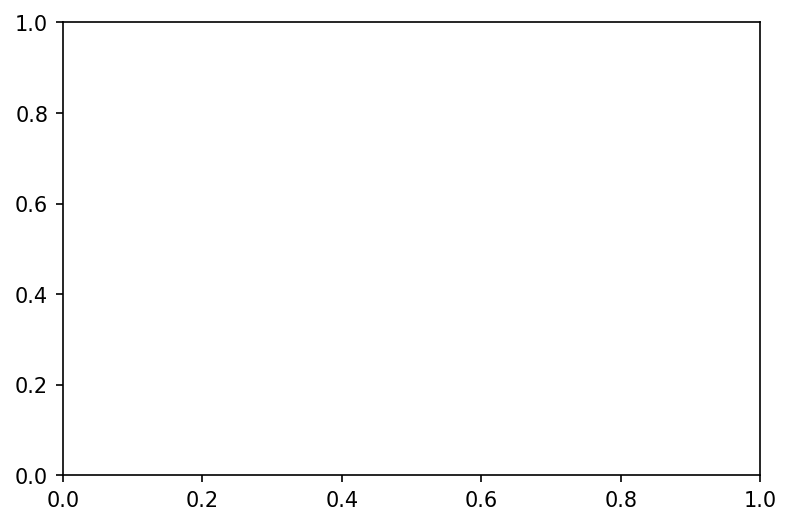

In [105]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_DAPI", y="feat_minor_axis_length_DAPI", s=1, alpha=0.5)

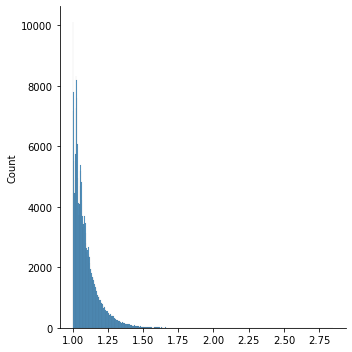

In [69]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(data=feat_majorminor_ratio)

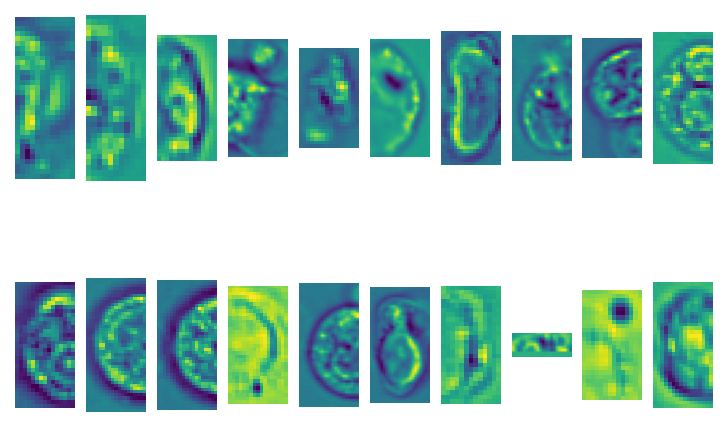

In [70]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [71]:
df = df[~sel1]
df.shape

(245308, 2519)

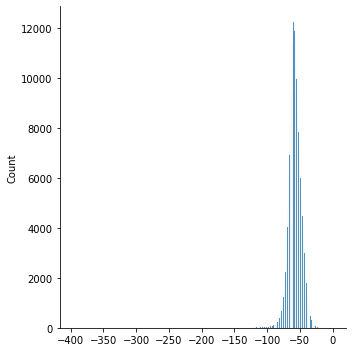

In [73]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

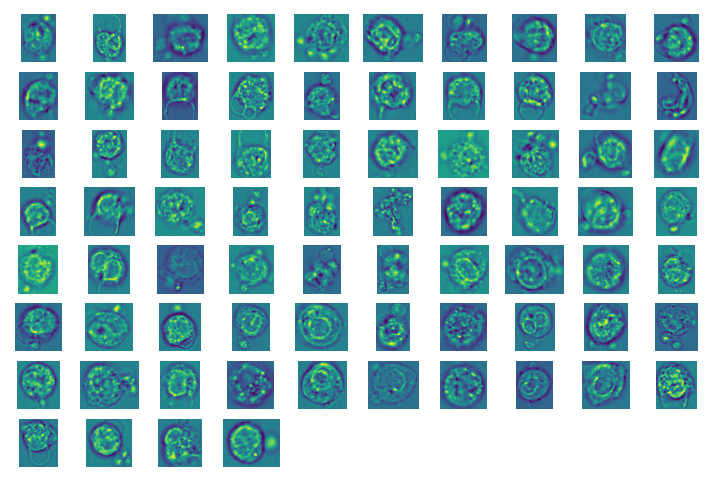

In [76]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -150
core.plot_gate_zarr(sel1, df)

In [77]:
df = df[~sel1]
df.shape

(245234, 2519)

KeyboardInterrupt: 

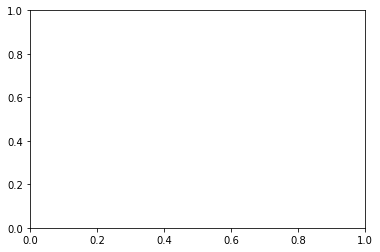

In [81]:
ax = seaborn.histplot(data=df, x="feat_eccentricity_BF1")

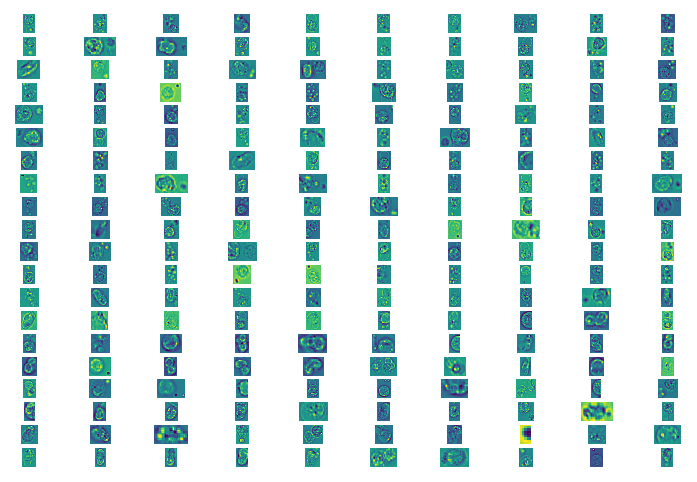

In [48]:
sel1 = df["feat_eccentricity_0"] > 0.8
core.plot_gate_zarr(sel1, df)

In [49]:
df = df[~sel1]
df.shape

(256831, 617)

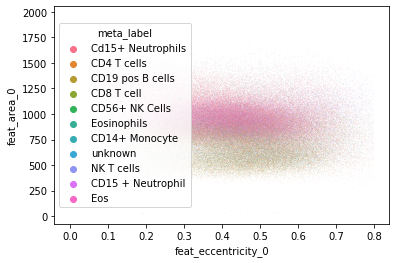

In [50]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_0", y="feat_area_0", s=0.1, alpha=0.5, hue="meta_label")

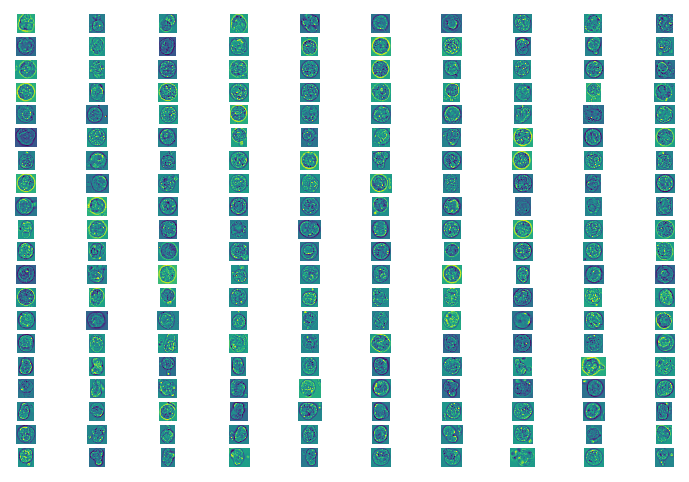

In [51]:
sel1 = df["feat_eccentricity_0"] > 0
sel2 = df["feat_area_0"] > 1500
core.plot_gate_zarr(sel1 & sel2, df)

In [220]:
df = df[~sel1]
df.shape

(118126, 408)

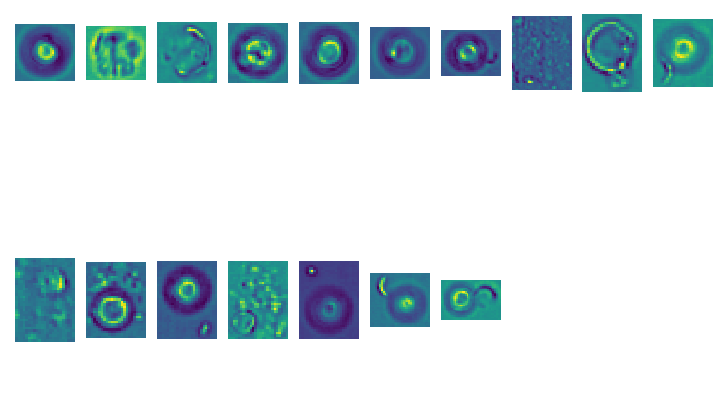

In [221]:
sel1 = df["feat_area_0"] > 500
sel2 = df["feat_eccentricity_0"] > 0.5
core.plot_gate_zarr(sel1 & sel2, df, sort="feat_eccentricity_0")

In [222]:
df = df[~(sel1 & sel2)]
df.shape

(118109, 408)

# Noisy events

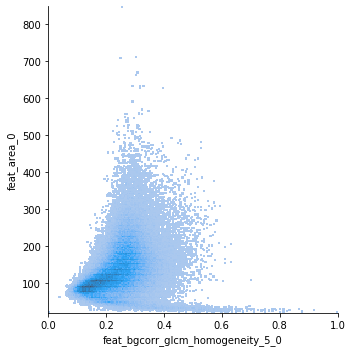

In [223]:
seaborn.displot(data=df, x="feat_bgcorr_glcm_homogeneity_5_0", y="feat_area_0")

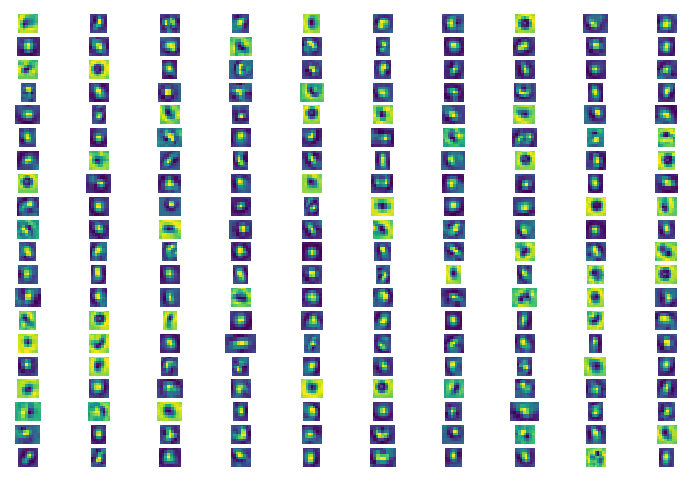

In [224]:
sel1 = df["feat_bgcorr_glcm_homogeneity_5_0"] > 0
sel2 = df["feat_area_0"] < 50
core.plot_gate_zarr(sel1 & sel2, df)

In [225]:
df = df[~(sel1 & sel2)]
df.shape

(114022, 408)

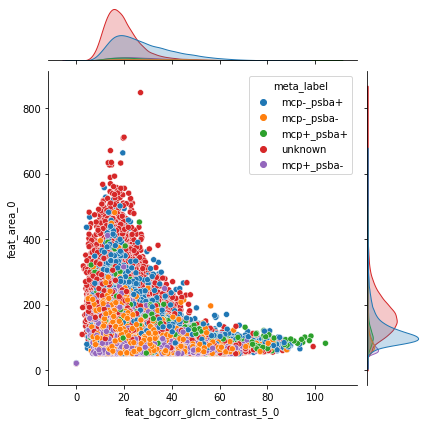

In [226]:
seaborn.jointplot(data=df, x="feat_bgcorr_glcm_contrast_5_0", y="feat_area_0", hue="meta_label")

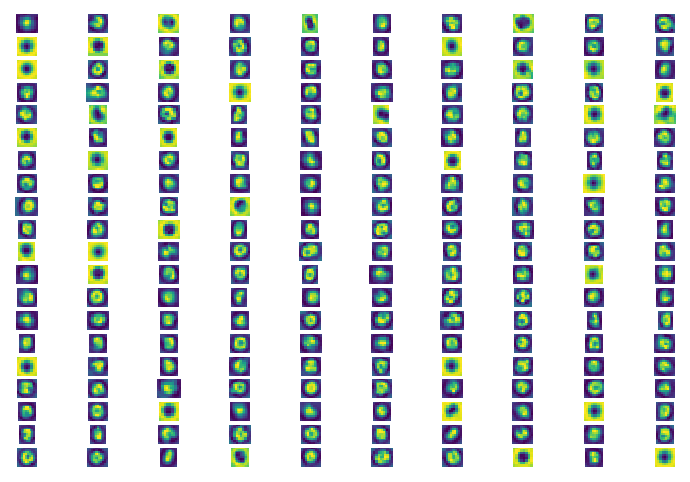

In [227]:
sel1 = df["feat_bgcorr_glcm_contrast_5_0"] > 60
core.plot_gate_zarr(sel1, df)

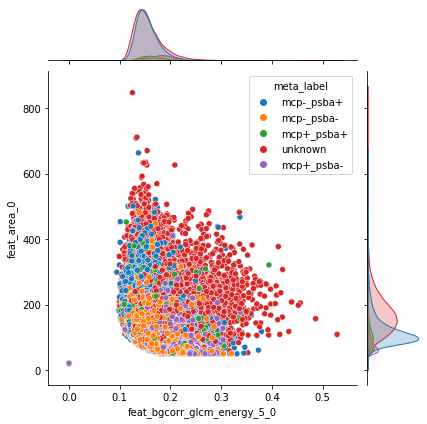

In [228]:
seaborn.jointplot(data=df, x="feat_bgcorr_glcm_energy_5_0", y="feat_area_0", hue="meta_label")

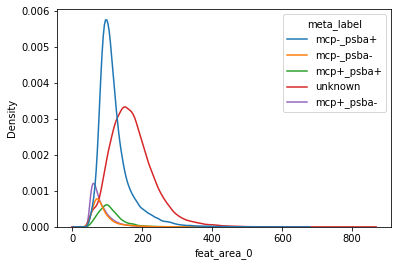

In [229]:
seaborn.kdeplot(data=df, x="feat_area_0", hue="meta_label")

In [230]:
df["meta_label"].value_counts()

unknown       53418
mcp-_psba+    45289
mcp+_psba-     6031
mcp+_psba+     4860
mcp-_psba-     4424
Name: meta_label, dtype: int64

# Distributions

In [52]:
df = df.drop(columns=df.filter(regex="feat").columns[df.filter(regex="feat").var().isna()])
df.shape

(256831, 617)

# Feature correlation

In [70]:
correlation = df.filter(regex="feat.*").corr()

## Overall feature correlation

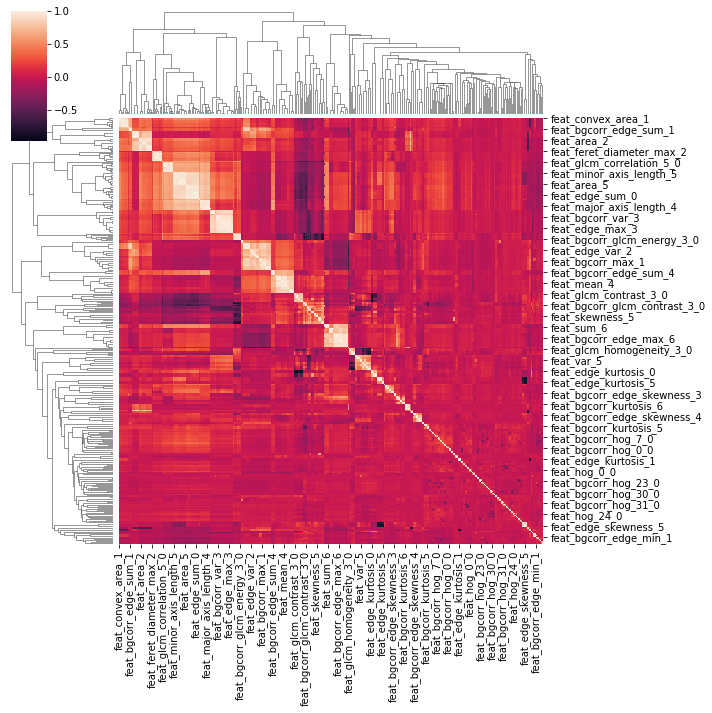

In [71]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

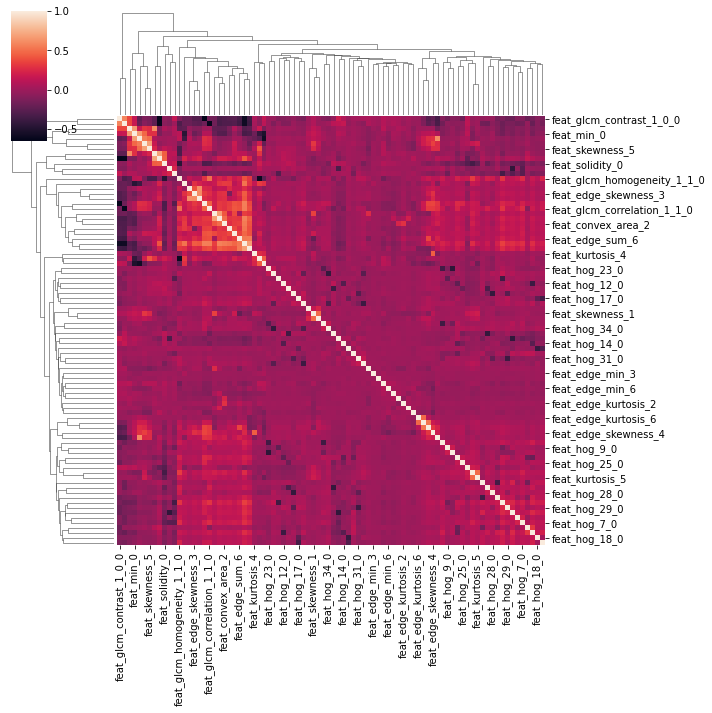

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [232]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202111161230/single_focused_index.npy", df.index.values)

In [53]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202111191528/columns.npy", df.columns.values)